In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import os

In [6]:
data = input_data.read_data_sets('data/fashion',one_hot=True,\
                                 source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 26421880 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 29515 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 4422102 bytes.
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 5148 bytes.
Extracting data/fashion\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/data

In [8]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=data.train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=data.train.labels.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=data.test.images.shape))
print("Test set (labels) shape: {shape}".format(shape=data.test.labels.shape))

Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000, 10)
Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000, 10)


In [9]:
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

Text(0.5, 1.0, '(Label: Ankle boot)')

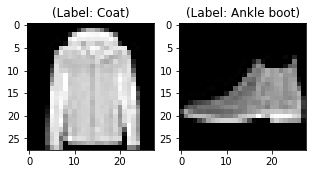

In [10]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(data.train.images[0], (28,28))
curr_lbl = np.argmax(data.train.labels[0,:])
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(data.test.images[0], (28,28))
curr_lbl = np.argmax(data.test.labels[0,:])
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [11]:
data.train.images[0][500:]

array([0.40784317, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03921569, 0.9568628 ,
       0.8588236 , 0.9803922 , 0.80392164, 0.7803922 , 0.8196079 ,
       0.79215693, 0.8196079 , 0.82745105, 0.7411765 , 0.83921576,
       0.8078432 , 0.8235295 , 0.7843138 , 0.8313726 , 0.6039216 ,
       0.94117653, 0.81568635, 0.8588236 , 0.54901963, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08235294, 1.        , 0.8705883 , 0.9333334 ,
       0.72156864, 0.8235295 , 0.75294125, 0.8078432 , 0.8196079 ,
       0.8235295 , 0.7411765 , 0.8352942 , 0.82745105, 0.8196079 ,
       0.75294125, 0.8941177 , 0.60784316, 0.8862746 , 0.9333334 ,
       0.9450981 , 0.6509804 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.14509805,
       0.9607844 , 0.8862746 , 0.9450981 , 0.5882353 , 0.7725491 ,
       0.7411765 , 0.8000001 , 0.8196079 , 0.8235295 , 0.71764

In [12]:
# Reshape training and testing image
train_X = data.train.images.reshape(-1, 28, 28, 1)
test_X = data.test.images.reshape(-1,28,28,1)

In [13]:
train_X.shape, test_X.shape

((55000, 28, 28, 1), (10000, 28, 28, 1))

In [14]:
train_y = data.train.labels
test_y = data.test.labels

In [15]:
train_y.shape, test_y.shape

((55000, 10), (10000, 10))

In [16]:
training_iters = 10
learning_rate = 0.001
batch_size = 128

In [ ]:
# MNIST data input (img shape: 28*28)
n_input = 28

# MNIST total classes (0-9 digits)
n_classes = 10